In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
plt.style.use('ggplot')

In [2]:
path_jags_output = 'data/jags_output/'

path_full = os.path.join(path_jags_output, 'pc_factorial_run1.mat')         
path_pi = os.path.join(path_jags_output, 'pc_factorial_run1_pi_only.mat')
path_pd = os.path.join(path_jags_output, 'pc_factorial_run1_pd_only.mat')
path_seq = os.path.join(path_jags_output, 'pc_seq_trick_run1.mat')
path_pdci = os.path.join(path_jags_output, 'pdci_run1.mat')

n_subjects = 32

### Check convergence
TODO list:
1. inspect traceplots
2. change hyperpriors on $\beta$
3. inspect distribution of $\beta$ and estimate values

In [3]:
def report_convergence(mat: dict) -> None:
    """Check for convergence of MCMC chains.

    Args:
        mat: loaded MATLAB structure containing stats field (JAGS output)
    """
    n_monit_nodes = 0    # total number of monitored nodes
    n_failed_nodes = 0   # number of nodes that failed to converge
    
    print('Looking for failed convergence...')
    for node in mat['stats']['Rhat'].item().dtype.names:
        
        rhats = mat['stats']['Rhat'].item()[node].item()
        rhats = np.array(rhats)
        ind_failed = rhats > 1.1 
        
        if np.any(ind_failed):
            n_failed_nodes += np.sum(ind_failed)
            message = (
                f"[--] node(s) {node} failed to converge\n"
                f"{5*' '}– {np.sum(ind_failed)}/{np.size(rhats)} fails, "
                f"max = {np.max(rhats[ind_failed]):0.2f}, "
                f"median = {np.median(rhats[ind_failed]):0.2f}"
            )
            print(message)
        else:
            print(f'[OK] node(s) {node} converged')
        n_monit_nodes += np.size(rhats)
        
    print('\nSummary:')
    print(f'{100*(1 - (n_failed_nodes/n_monit_nodes)):0.2f}% nodes converged\n\n')
    
def plot_z_convergence(rhat_z: np.array) -> None:
    """Plots r-hat barplot for indicator variable"""
    
    rhat_thr = 1.1
    n_subjects = np.size(rhat_z)

    fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='w', figsize=(20, 4))
    b = ax.bar(
        range(n_subjects), 
        rhat_z,
        color=[.3, .3, .3]
    )

    for rect in b:
        if rect.get_height() > rhat_thr:
            rect.set_color([1, .3, .3])
    
    ax.set_title('Model indicator variable $z_i$')
    
    ax.set_xlim((-1, n_subjects))
    ax.set_xlabel('Subjects')
    ax.set_xticks(range(n_subjects))
    ax.set_xticklabels([f'm{sub:02}' for sub in range(2, n_subjects+2)],
                      rotation=-45);

    ax.set_ylim((1, 1.4))
    ax.set_ylabel(r'$\hat{r}$', rotation=0)

    ax.plot(ax.get_xlim(), (rhat_thr, rhat_thr), color='r')
    
    plt.tight_layout()
    plt.savefig('pygures/convergence.png')

In [4]:
print('=== HM PDCI ===')
mat = scipy.io.loadmat(path_pdci, variable_names=['stats'], squeeze_me=True)
report_convergence(mat)

=== HM PDCI ===
Looking for failed convergence...
[OK] node(s) theta converged
[OK] node(s) alpha_pdci converged
[OK] node(s) beta_pdci converged
[OK] node(s) a_alpha_pdci converged
[OK] node(s) b_alpha_pdci converged
[OK] node(s) mu_beta_pdci converged
[OK] node(s) sigma_beta_pdci converged
[OK] node(s) deviance converged

Summary:
100.00% nodes converged




=== HLM Sequential ===
Looking for failed convergence...
[--] node(s) z failed to converge
     – 2/32 fails, max = 1.11, median = 1.11
[OK] node(s) a_alpha_pici converged
[OK] node(s) b_alpha_pici converged
[OK] node(s) mu_beta_pici converged
[OK] node(s) sigma_beta_pici converged
[--] node(s) alpha_pici failed to converge
     – 1/32 fails, max = 1.12, median = 1.12
[OK] node(s) beta_pici converged
[--] node(s) a_alpha_picd failed to converge
     – 1/2 fails, max = 1.56, median = 1.56
[OK] node(s) b_alpha_picd converged
[OK] node(s) mu_beta_picd converged
[OK] node(s) sigma_beta_picd converged
[--] node(s) alpha_picd failed to converge
     – 32/64 fails, max = 1.77, median = 1.25
[OK] node(s) beta_picd converged
[OK] node(s) a_alpha_pdci converged
[OK] node(s) b_alpha_pdci converged
[OK] node(s) mu_beta_pdci converged
[OK] node(s) sigma_beta_pdci converged
[--] node(s) alpha_pdci failed to converge
     – 6/64 fails, max = 1.72, median = 1.24
[OK] node(s) beta_pdci converged
[--] n

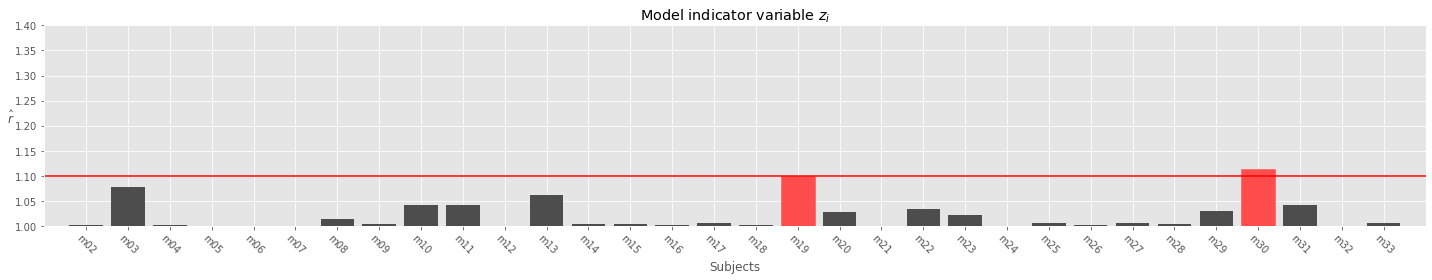

In [5]:
print('=== HLM Sequential ===')
mat = scipy.io.loadmat(path_seq, variable_names=['stats'], squeeze_me=True)
report_convergence(mat)
plot_z_convergence(mat['stats']['Rhat'].item()['z'].item())